In [1]:
import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from IPython import display
import imageio
import numpy as np
import pandas as pd

import grid_world as _
from grid_world.envs.grid_world_env_v6 import GridWorldEnv_v6
import gymnasium as gym
from gymnasium.wrappers import ResizeObservation

import torch
import torch.nn as nn
from torchvision import transforms
from resnet.models import ResNet

import ray
from ray import tune
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.algorithm import Algorithm
from ray.tune.registry import register_env

In [2]:
ENV = 'grid_world/GridWorld-v6'
RASTER_DIR = Path('/home/ben/raster/cost_surfaces/10km_112nat_336reg_672loc/')
MAX_DISTANCE = 50   # max starting distance of agent to target in both dimensions
NUM_WORKERS = 20    # number of roll out workers
OBS_SIZE = 112      # observation width and height
DISTANCE_GOAL = 10  # proximity of agent to target required for episode termination
OBS_RADIUS = 5      # size of circle on obs which represents agent and target
CHECKPOINT = '/home/ben/ray_results/PPO_GridWorldEnv_v6_2023-11-29_07-58-52pxjvs34x/checkpoint_000191'
# CHECKPOINT = None
MAX_STEPS = 500     # maximum number of agent steps in an episode
# LR = 1e-6
LR_SCHEDULE = [[0, 5e-5], [40e4, 1e-5], [80e4, 5e-6], [120e4, 1e-6], [160e4, 5e-7]]

In [3]:
national = np.load(RASTER_DIR.joinpath('national.npy'))
regional = np.load(RASTER_DIR.joinpath('regional.npy'))
local = np.load(RASTER_DIR.joinpath('local.npy'))
no_go = np.load(RASTER_DIR.joinpath('no_go.npy'))

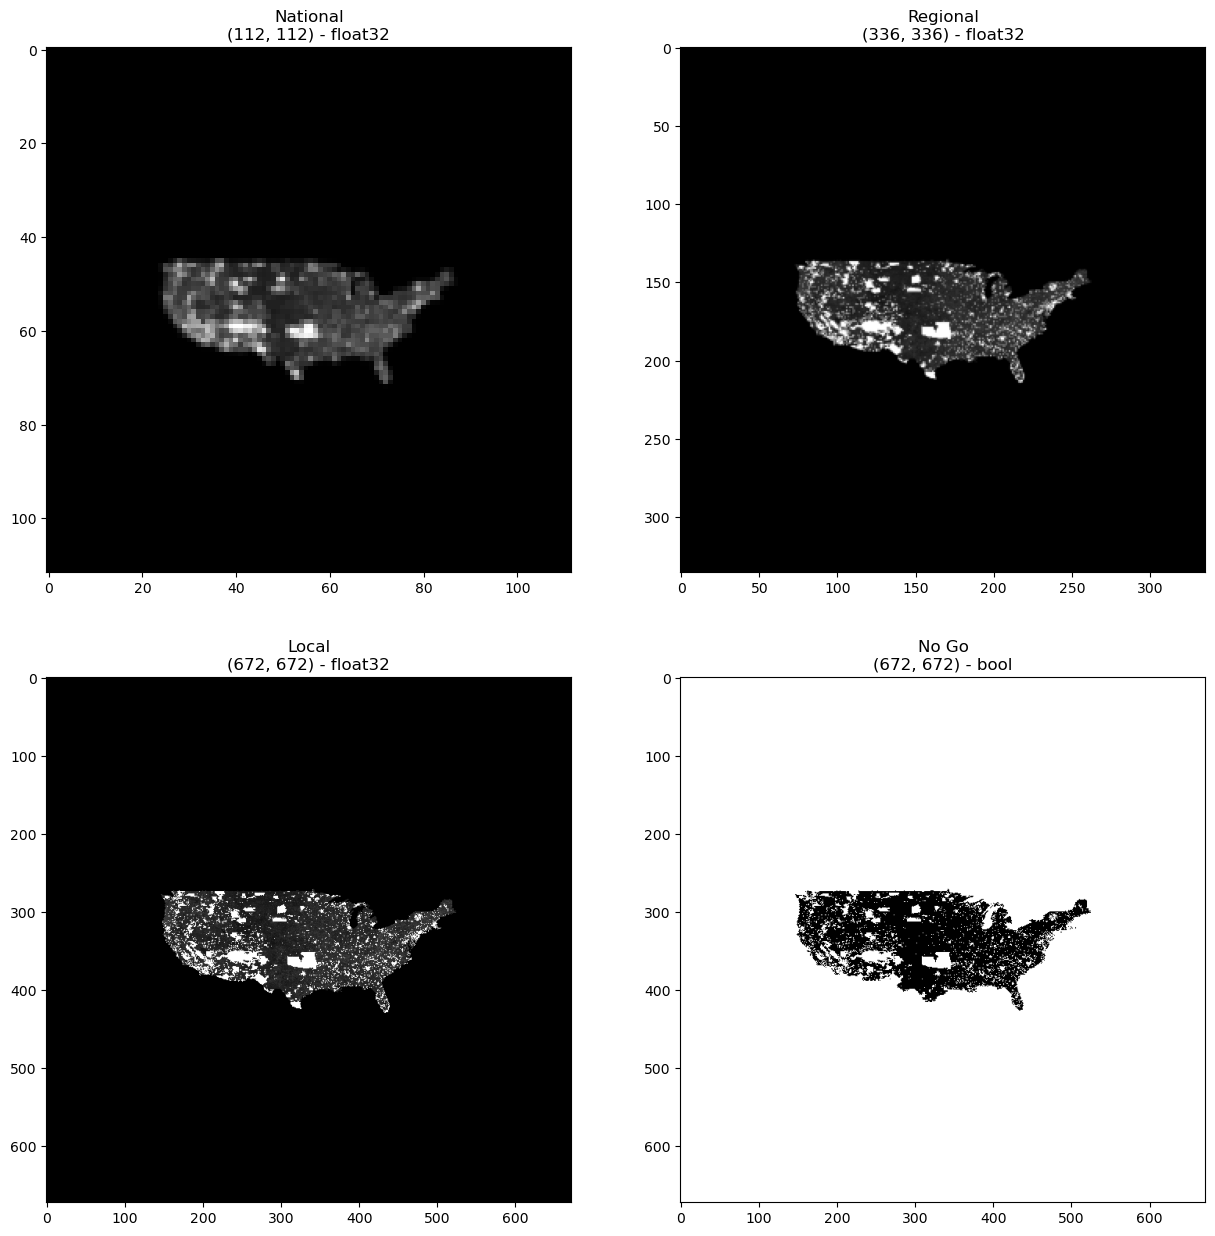

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

ax[0,0].set_title('National\n{} - {}'.format(national.shape, national.dtype))
ax[0,0].imshow(national, cmap='gray')

ax[0,1].imshow(regional, cmap='gray')
ax[0,1].set_title('Regional\n{} - {}'.format(regional.shape, regional.dtype))

ax[1,0].imshow(local, cmap='gray')
ax[1,0].set_title('Local\n{} - {}'.format(local.shape, local.dtype))

ax[1,1].imshow(no_go, cmap='gray')
ax[1,1].set_title('No Go\n{} - {}'.format(no_go.shape, no_go.dtype))

plt.show()

In [5]:
env_config = {
    'env': ENV,
    'size': OBS_SIZE,
    'max_distance': MAX_DISTANCE,
    'start': None,
    'target': None,
    'distance_goal': DISTANCE_GOAL,
    'obs_radius': OBS_RADIUS,
    'render_mode': None,
    'national': national,
    'regional': regional,
    'local': local,
    'no_go': no_go,
    'max_steps': MAX_STEPS
    }

In [6]:
env = gym.make(ENV, env_config=env_config)
observation, info = env.reset()
env.close()

In [8]:
env.action_space

Discrete(8)

In [9]:
print(observation.shape)
print(observation.min())
print(observation.max())
print(observation.dtype)

(9, 112, 112)
0.0
1.0
float32


In [10]:
national_obs = observation[:3,:,:]
regional_obs = observation[3:6,:,:]
local_obs = observation[6:,:,:]

national_img = np.moveaxis(national_obs, 0, -1)
regional_img = np.moveaxis(regional_obs, 0, -1)
local_img = np.moveaxis(local_obs, 0, -1)

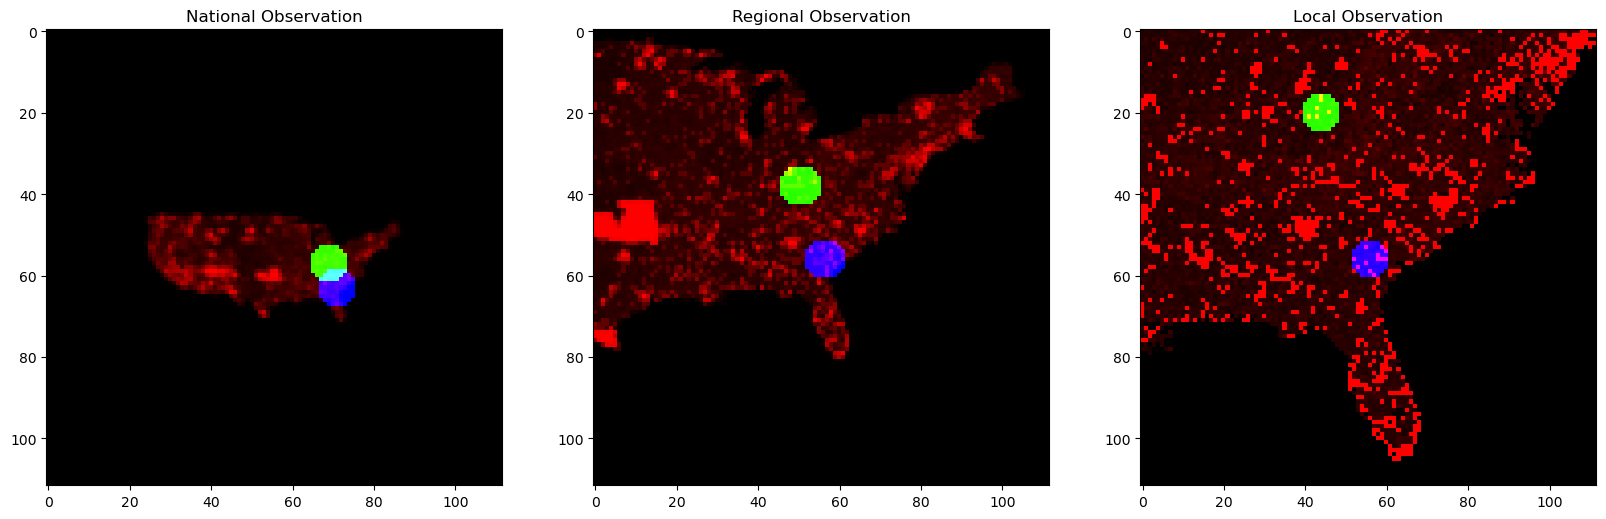

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(20,10))

ax[0].set_title('National Observation')
ax[0].margins(0.01)
ax[0].imshow(national_img)

ax[1].set_title('Regional Observation')
ax[1].margins(0.01)
ax[1].imshow(regional_img)

ax[2].set_title('Local Observation')
ax[2].margins(0.01)
ax[2].imshow(local_img)

plt.show()

In [12]:
national = observation[:3,:,:]
regional = observation[3:6,:,:]
local = observation[6:,:,:]
full = np.concatenate((national, regional, local), axis=0)
tensor = torch.tensor(full)

expected_shape = torch.Size((9,112,112))

# This should give the same warning as when the forward logic tried to convert the observation into a tensor
copy_of_tensor = torch.tensor(tensor)

assert isinstance(full, np.ndarray), 'Not a numpy array'
assert isinstance(tensor, torch.Tensor), 'Not a torch tensor'
assert expected_shape == tensor.shape, 'Did not return expected shape'

print(national.shape)
print(regional.shape)
print(local.shape)
print(full.shape)
print(tensor.shape)

print(national.dtype)
print(regional.dtype)
print(local.dtype)
print(full.dtype)
print(tensor.dtype)

(3, 112, 112)
(3, 112, 112)
(3, 112, 112)
(9, 112, 112)
torch.Size([9, 112, 112])
float32
float32
float32
float32
torch.float32


/tmp/ipykernel_9903/717032803.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  copy_of_tensor = torch.tensor(tensor)


In [13]:
def env_creator(env_config):

    return GridWorldEnv_v6(env_config)

In [14]:
class ResNetDQN(nn.Module):
    def __init__(self, in_channels, num_blocks, n_actions) -> None:
        super(ResNetDQN, self).__init__()
        self.encoder = ResNet(in_channels, num_blocks)
        self.linear = nn.Linear(256, n_actions)

    def forward(self, x) -> torch.Tensor:
        x = self.encoder(x)
        x = self.linear(x)
        return x

In [15]:
test_model = ResNetDQN(in_channels=9, num_blocks=3, n_actions=8)
x = torch.rand(size=(1,9,112,112))

with torch.no_grad():
    y = test_model(x)
print(y)

tensor([[ 0.5255,  0.0037,  0.5022,  0.1180, -0.7465, -0.0420, -0.0427,  0.1312]])


In [16]:
test_model = ResNetDQN(in_channels=9, num_blocks=3, n_actions=8)
x = torch.tensor(observation).unsqueeze(dim=0)
print(x.shape)

with torch.no_grad():
    y = test_model(x)
print(y)

torch.Size([1, 9, 112, 112])
tensor([[-0.3127, -0.4473,  0.1238,  0.4389, -0.1319, -0.8689, -0.0133,  0.2706]])


In [17]:
ray.shutdown()
ray.init(ignore_reinit_error=True, include_dashboard=False)

2023-12-12 07:25:45,629	INFO worker.py:1636 -- Started a local Ray instance.


Python version:,3.11.5
Ray version:,2.5.0


In [18]:
register_env(ENV, env_creator)

In [19]:
class CustomTorchModel(TorchModelV2, nn.Module):
    
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super(CustomTorchModel, self).__init__(obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        self.encoder = ResNet(in_channels=9, num_blocks=3)
        self.policy_fc = nn.Linear(in_features=256, out_features=action_space.n)
        self.value_fc = nn.Linear(in_features=256, out_features=1)
    
    def forward(self, input_dict, state, seq_lens):
        is_training = input_dict.is_training
        observation = input_dict['obs']

        assert isinstance(observation, torch.Tensor)
        # assert observation.shape[]
        # tensor = torch.tensor(observation).to(torch.float)
        # tensor = torch.tensor(observation, dtype=torch.float)
        # tensor = torch.moveaxis(observation, -1, 1)
        encoded_obs = self.encoder(observation)
        logits = self.policy_fc(encoded_obs)
        self.state_value = self.value_fc(encoded_obs)

        return logits, []
    
    def value_function(self):
        return self.state_value.squeeze(-1)

ModelCatalog.register_custom_model("my_torch_model", CustomTorchModel)

In [20]:
model_config = {
    'custom_model': 'my_torch_model',
    'custom_model_config': {},
    # 'dim': OBS_SIZE
}


config = PPOConfig()

# config = ppo.PPO(env='pac-man', config=algo_config)
# config.env_config.update(
#         {
#         'env': ENV,
#         'cost_surface': cost_surface,
#         'size': OBS_SIZE,
#         'max_distance': MAX_DISTANCE,
#         'start': None,
#         'target': None,
#         'distance_goal': DISTANCE_GOAL,
#         'obs_radius': OBS_RADIUS 
#         }
#     )

# Define the environment
config = config.environment(GridWorldEnv_v6, env_config=env_config)

# Give or do not give access to the gpu
config = config.resources(num_gpus=0)

# Set the number of training roll out workers
config = config.rollouts(num_rollout_workers=NUM_WORKERS)

config.model.update(model_config)

# Set the max number of episode steps
# config.horizon = 30

# Set the number of evaluation workers
# config = config.evaluation(evaluation_num_workers=1)

# Set framework to pytorch
config = config.framework('torch')

# These lines are needed to avoid using the RL Module API currently in Alpha
# config = config.rl_module( _enable_rl_module_api=False)
# config = config.training(_enable_learner_api=False)
config.lr_schedule = LR_SCHEDULE


In [21]:
# print(config.exploration_config)
# print(config.env_config)
# print(config.model)
print(config.lr_schedule)

[[0, 5e-05], [400000.0, 1e-05], [800000.0, 5e-06], [1200000.0, 1e-06], [1600000.0, 5e-07]]


In [22]:
if CHECKPOINT is not None and Path(CHECKPOINT).exists():
    print('Loading model from {}'.format(CHECKPOINT))
    algo = Algorithm.from_checkpoint(CHECKPOINT)

else:
    print('Training a new model...')
    algo = config.build()

Loading model from /home/ben/ray_results/PPO_GridWorldEnv_v6_2023-11-29_07-58-52pxjvs34x/checkpoint_000191


/home/ben/miniconda3/envs/ray/lib/python3.11/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/ben/miniconda3/envs/ray/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/ben/miniconda3/envs/ray/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated an

In [23]:
def plot_training(progress_path, done=False):
    
    df = pd.read_csv(progress_path)
    fig = plt.figure(1, figsize=(24,16))
    plt.clf()

    ax1 = fig.add_subplot(2, 3, 1) # rows, cols, pos
    ax1.set_title('Mean Episode Reward')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Mean Reward')
    ax1.plot(df['episode_reward_mean'])

    ax2 = fig.add_subplot(2, 3, 2)
    ax2.set_title('Episode Length')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Mean Number of Timesteps')
    ax2.plot(df['episode_len_mean'])

    ax3 = fig.add_subplot(2, 3, 3)
    ax3.set_title('Learning Rate')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Learning Rate')
    ax3.plot(df['info/learner/default_policy/learner_stats/cur_lr'])

    # ax4 = fig.add_subplot(2, 3, 4)
    # ax4.set_title('Testing Loss')
    # ax4.set_xlabel('Testing Interval')
    # ax4.set_ylabel('Loss - BCE')
    # ax4.plot(test_loss)

    # ax5 = fig.add_subplot(2, 3, 5)
    # ax5.set_title('Testing IoU')
    # ax5.set_xlabel('Testing Interval')
    # ax5.set_ylabel('Learning Rate')
    # ax5.plot(test_iou)

    # ax6 = fig.add_subplot(2, 3, 6)
    # ax6.set_title('Open')
    # ax6.set_xlabel('NA')
    # ax6.set_ylabel('NA')
    # # ax6.plot(test_loss)

    if not done:
        display.display(plt.gcf())
        display.clear_output(wait=True)

    else:
        display.display(plt.gcf())

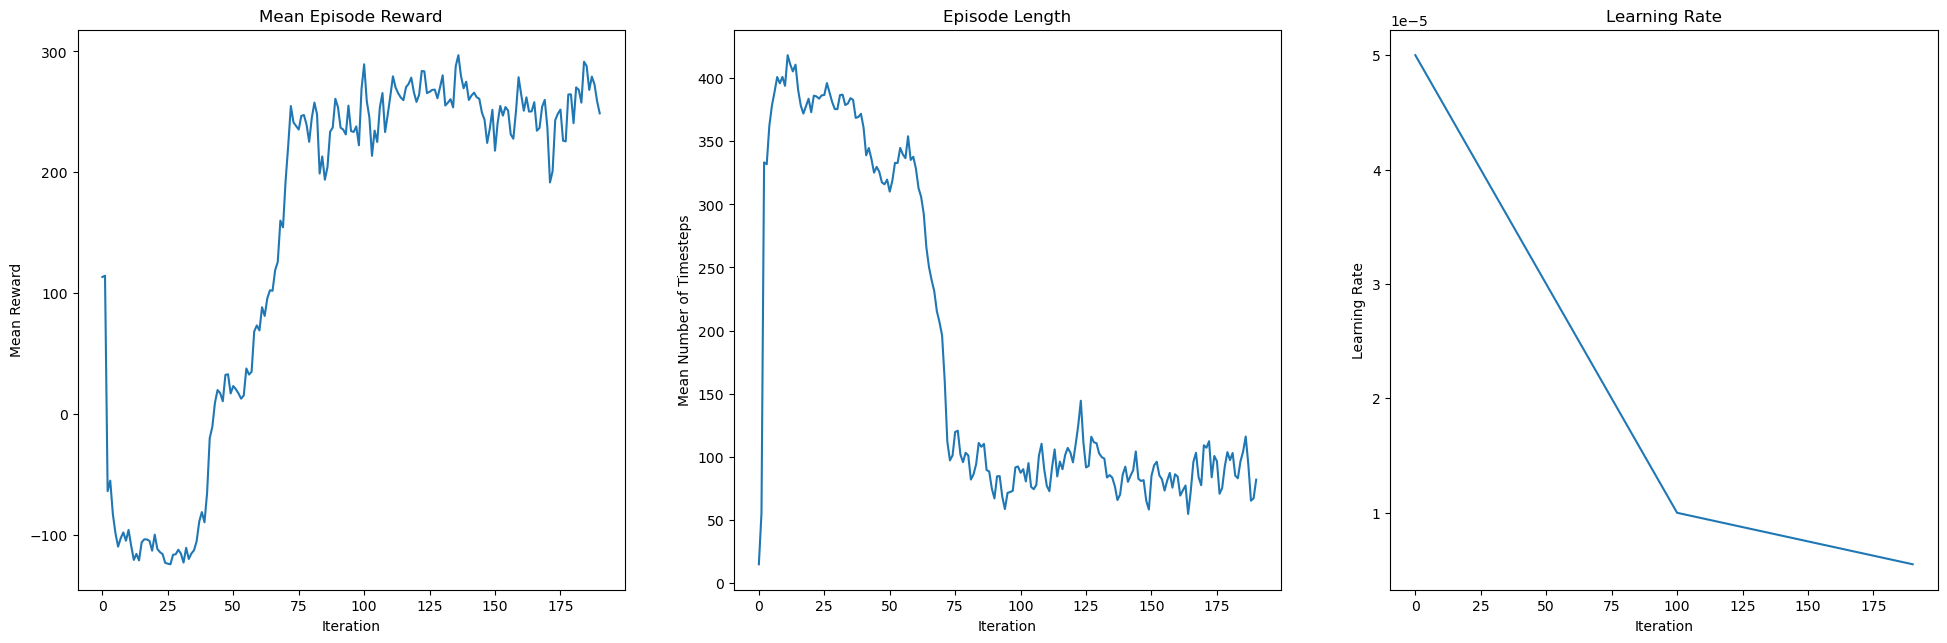

In [24]:
progress_path = Path(CHECKPOINT).parent.joinpath('progress.csv')
# progress_path = '/home/ben/ray_results/PPO_GridWorldEnv_v6_2023-11-21_07-53-244sc5fic1/progress.csv'
import time
for i in range(5):
    time.sleep(0.5)
    plot_training(progress_path, done=False)

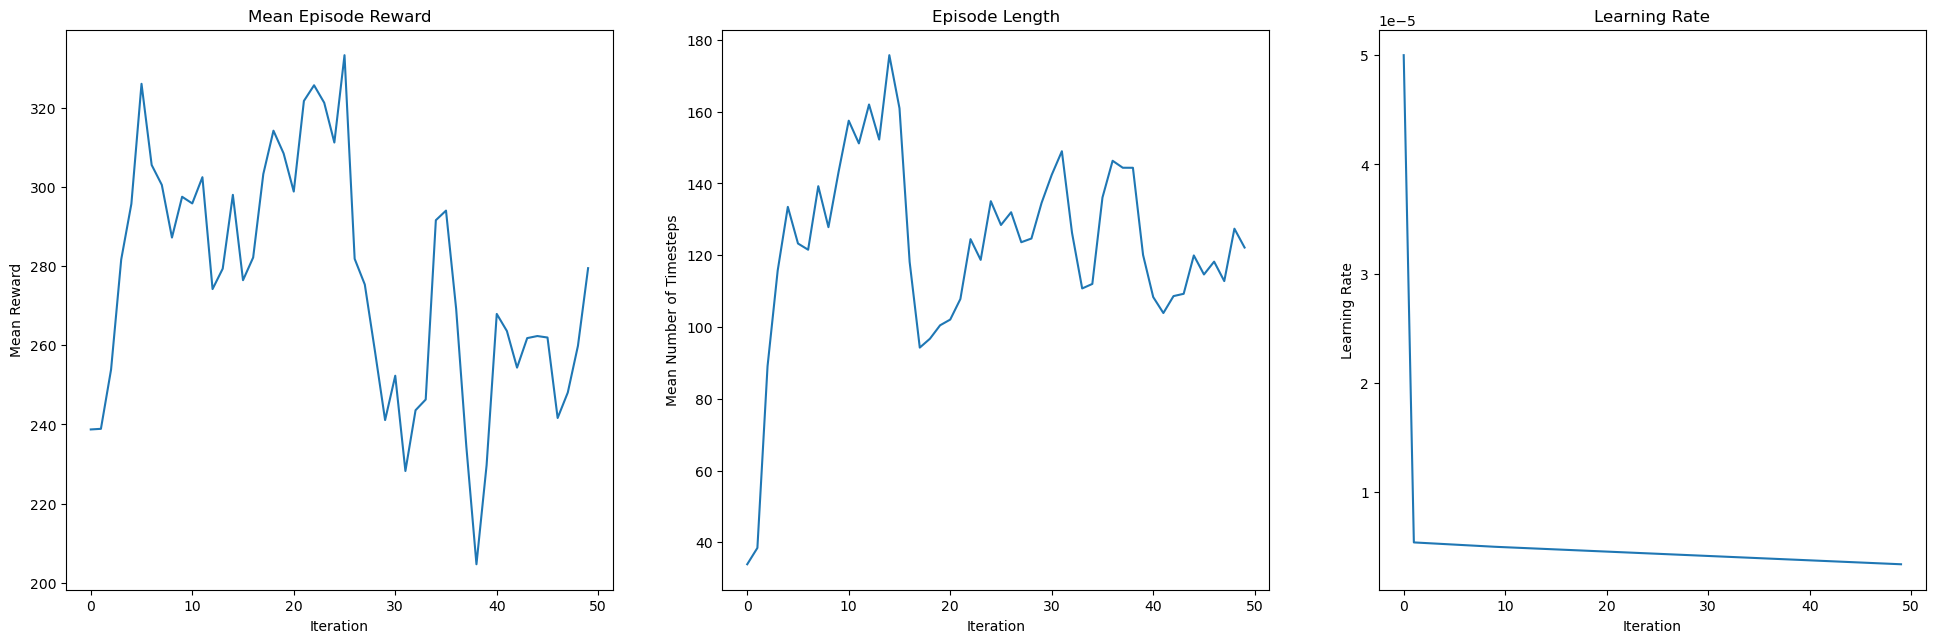

(raylet) [2023-12-08 07:18:02,474 E 24675 24675] (raylet) node_manager.cc:3069: 29 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 813e380a82c932b27d48353f3087d95d7bb6175798db1be569b6418e, IP: 172.25.250.123) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.25.250.123`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2023-12-08 07:19:02,965 E 24675 24675] (raylet) node_manager.cc:3069: 37 Workers (tasks / actors) kill

In [54]:
TRAINING_ITERATIONS = 50
# EVAL_INTERVAL = 1
CHECKPOINT_INTERVAL = 5
checkpoint_paths = []
progress_path = None

# if CHECKPOINT is not None:
#     progress_path = Path(CHECKPOINT).parent.joinpath('progress.csv')
# else:
#     progress_path = None


# for i in tqdm.tqdm(range(TRAINING_ITERATIONS), 'Training Progress'):
for i in range(TRAINING_ITERATIONS):
    
    algo.train()

    if i % CHECKPOINT_INTERVAL == 0:
        checkpoint_paths.append(algo.save())
        # metrics = algo.evaluate()['evaluation']
        # rewards.append(metrics['episode_reward_mean'])
        # lengths.append(metrics['episode_len_mean'])
        # plot_metrics(rewards, lengths)
    if progress_path is None:
        progress_path = progress_path = Path(checkpoint_paths[-1]).parent.joinpath('progress.csv')
    plot_training(progress_path, done=False)

In [45]:
0%5

0

It appears that the newer version of ray automatically attempts to transform the observation based model configurations. In older versions if you had to perform the transformation step yourself. Thus, the cell block below is no longer necessary and will give an error if you attempt to transform the observation before it is passed to the ray algorithm.

In [34]:
env = gym.make(ENV, env_config=env_config)
# env = ResizeObservation(env, 112)
observation, info = env.reset()
print(observation.shape)
action = algo.compute_single_action(observation)
print(action)
env.close()
# transformer = transforms.ToTensor()
# tensor = transformer(observation).unsqueeze(0)
# print(tensor.shape)

(9, 112, 112)
5


In [32]:
env_config_rgb = env_config.copy()
env_config_rgb['render_mode'] = 'rgb_array'
env = gym.make(ENV, env_config=env_config_rgb)
observation_images = []
# env = gym.make(ENV)
# env = ResizeObservation(env, 112)

observation, info = env.reset()
# tensor = transformer(observation).unsqueeze(0)

for _ in range(1000):
   # action = algo.compute_single_action(tensor)
   observation_images.append(env.render())
   action = algo.compute_single_action(observation)
   observation, reward, terminated, truncated, info = env.step(action)
   # tensor = transformer(observation).unsqueeze(0)


   if terminated or truncated:
      observation_images.append(env.render())
      observation, info = env.reset()
      # tensor = transformer(observation).unsqueeze(0)


env.close()
fps=480
duration = 1000/fps # duration in ms
imageio.mimsave('/home/ben/gym/grid/gifs/ppo-0280.gif', observation_images, duration=duration)  

(raylet) [2023-11-07 06:30:26,545 E 1188 1188] (raylet) node_manager.cc:3069: 5 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: dee19ccdd8d13e0450d25bcde6d969862ff5642a01bb1d1d2185fcb1, IP: 172.25.20.16) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.25.20.16`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2023-11-07 06:31:26,548 E 1188 1188] (raylet) node_manager.cc:3069: 3 Workers (tasks / actors) killed due to 

In [27]:
# Export the policy
policy = algo.get_policy()
policy.export_model('/home/ben/gym/grid/trained_model')